In [4]:
#import data
import pandas as pd
import numpy as np

data = pd.read_csv("output_site_10292.csv")
data

,Hot Water Outlet Temperature (C),Hot Water Average Temperature (C),T_WH1 Temperature (C),Draw Data (L),Setpoint (C)
0,39.381536,39.410586,39.381536,0.000000,45.560000
1,39.314832,39.374383,39.314832,0.000000,45.560000
2,39.341707,39.338256,39.341707,0.000000,45.560000
3,39.273645,39.302194,39.273645,0.000000,42.594667
4,39.206348,39.266208,39.206348,0.000000,40.000000
...,...,...,...,...,...
844794,57.386532,53.673807,57.386532,0.000000,60.000000
844795,58.592962,55.491008,58.592962,0.000000,59.733333
844796,59.493777,56.521571,59.493777,0.000000,59.500000
844797,59.446822,56.457845,59.446822,0.000000,59.500000


In [5]:
#Data transformation, Y-values are y_i+1 temperatures for the next hour
def rolling_subsets(input_list, window_size = 4):
    if window_size > len(input_list) or window_size <= 0:
        raise ValueError("Window size must be positive and not greater than the list length.")
    
    return [input_list[i:i + window_size] for i in range(len(input_list) - window_size + 1)]

#converts dataframe to 1 hour feature windows
def csv_to_features(df):
    y_col = df["Hot Water Outlet Temperature (C)"]
    window = 4
    result = rolling_subsets(y_col, window)
    
    #create feature vectors
    x1 = df["Hot Water Average Temperature (C)"]
    x2 = rolling_subsets(df["Draw Data (L)"], window)
    x3 = rolling_subsets(df["Setpoint (C)"], window)
    x4 = df["T_WH1 Temperature (C)"]
    print(len(y_col), len(x2), len(x2))
    y = result[1:] #remove the first index to offset, y = i+1th prediction
    x1_v = x1[:-4] #remove last 4
    x2_v = x2[:-1] 
    x3_v = x3[:-1]
    x4_v = x4[:-4] #current top node temp
    print(len(y), len(x1_v), len(x2_v), len( x3_v))
    X = np.column_stack([x1_v, x2_v, x3_v, x4_v])
    return X, y

In [6]:
X, y = csv_to_features(data)

print(data.head())

844799 844796 844796
844795 844795 844795 844795
   Hot Water Outlet Temperature (C)  Hot Water Average Temperature (C)  \
0                         39.381536                          39.410586   
1                         39.314832                          39.374383   
2                         39.341707                          39.338256   
3                         39.273645                          39.302194   
4                         39.206348                          39.266208   

   T_WH1 Temperature (C)  Draw Data (L)  Setpoint (C)  
0              39.381536            0.0     45.560000  
1              39.314832            0.0     45.560000  
2              39.341707            0.0     45.560000  
3              39.273645            0.0     42.594667  
4              39.206348            0.0     40.000000  


In [7]:
#Train test split 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train,y_train)
r_sq = model.score(X_train, y_train)
print(f"Training coefficient of determination: {r_sq}")
y_predict = model.predict(X_test)
test_r_sq = model.score(X_test, y_test)
print(f"Test coefficient of determination: {test_r_sq}")
mse = mean_squared_error(y_test, y_predict, multioutput='uniform_average')
print("Mean Squared Error:", mse)

Training coefficient of determination: 0.9820318970114058
Test coefficient of determination: 0.9822435724548488
Mean Squared Error: 0.5254870671136677


In [22]:
import numpy as np
from sklearn.metrics import mean_squared_error

def regression_sums(y_true, y_pred):
    # Compute RSS
    rss = np.sum((y_true - y_pred) ** 2, axis=0)  # Sum over all samples, keep output dimensions

    # Compute TSS
    y_mean = np.mean(y_true, axis=0)  # Mean of true values for each output
    tss = np.sum((y_true - y_mean) ** 2, axis=0)

    # Compute ESS
    ess = tss - rss

    # Compute R² for each output variable
    r_squared = 1 - (rss / tss)

    return {
        "RSS": rss,
        "TSS": tss,
        "ESS": ess,
        "R²": r_squared
    }


results = regression_sums(y_test, y_predict)
print("RSS:", results["RSS"])
print("TSS:", results["TSS"])
print("ESS:", results["ESS"])
print("R²:", results["R²"])


RSS: [818110.56551598 797311.15598293 795953.97375297 813584.65835774]
TSS: [57794770.38929871 57791894.31030167 57788432.96659814 57793826.95856208]
ESS: [56976659.82378272 56994583.15431874 56992478.99284516 56980242.30020434]
R²: [0.98584456 0.98620375 0.98622641 0.98592264]


In [32]:
error = (y_test[0] - y_predict[0]) / y_test[0]
#np.sum(error)/len(error)
error


901850    0.003340
901851    0.000847
901852    0.000925
901853    0.000027
Name: Hot Water Outlet Temperature (C), dtype: float64

In [13]:
#validation test
val_data = pd.read_csv("output_site_10441.csv")
X_val, y_val = csv_to_features(val_data)

#error metrics
from sklearn.metrics import r2_score
y_predict_val = model.predict(X_val)

r_2_val = r2_score(y_val, y_predict_val)
print(f"test coefficient of determination: {r_2_val}")

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_val, y_predict_val, multioutput='uniform_average')
print("Mean Squared Error:", mse)



660479 660476 660476
660475 660475 660475 660475
test coefficient of determination: 0.9855806514184542
Mean Squared Error: 0.4041440242051584


In [29]:
val_data

,Hot Water Outlet Temperature (C),Hot Water Average Temperature (C),T_WH1 Temperature (C),Draw Data (L),Setpoint (C)
0,39.381536,39.410586,39.381536,0.000000,40.000
1,39.314832,39.374383,39.314832,0.000000,40.000
2,39.341707,39.338256,39.341707,0.000000,40.000
3,39.273645,39.302194,39.273645,0.000000,40.000
4,39.206348,39.266208,39.206348,0.000000,40.000
...,...,...,...,...,...
660474,56.467252,49.383905,56.467252,0.000000,53.940
660475,56.340074,49.332711,56.340074,0.000000,57.172
660476,56.214288,49.281593,56.214288,0.000000,60.000
660477,56.237982,47.706795,56.237982,0.757082,60.000


C:\Users\janel\AppData\Local\Temp\ipykernel_28148\2392425390.py:25: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_list = pd.date_range(start=start_time, end=end_time, freq="15T")


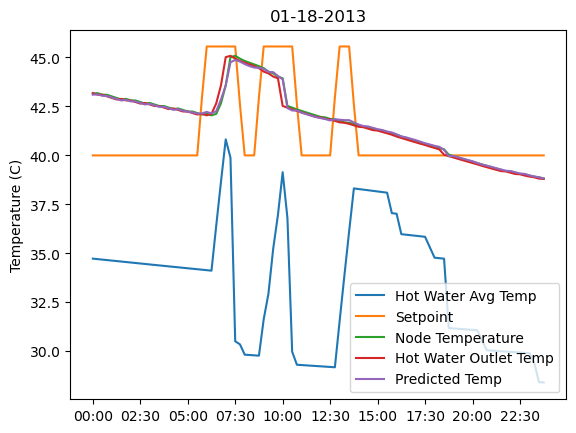

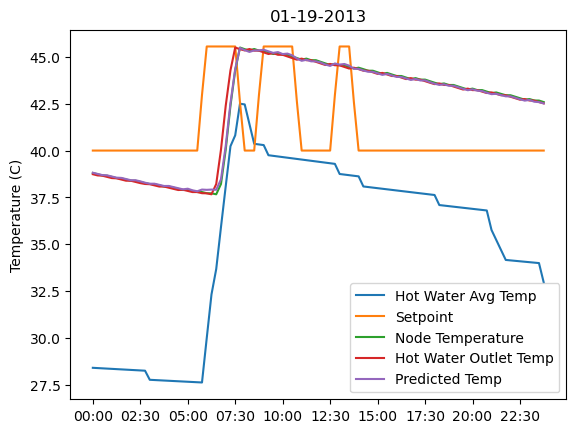

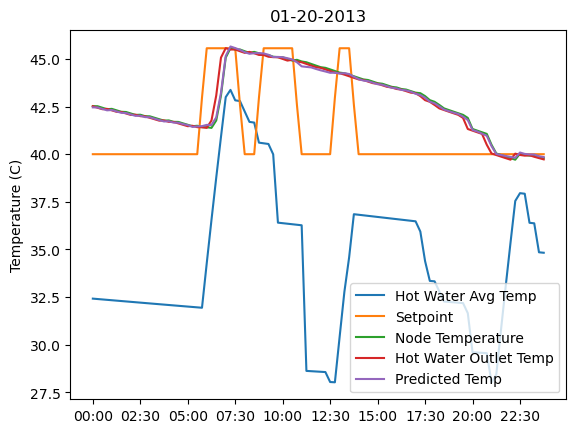

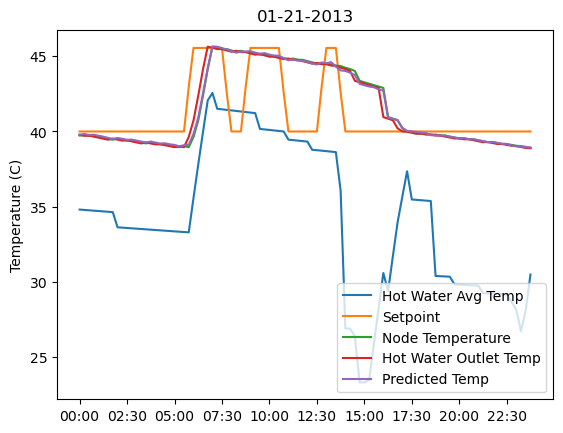

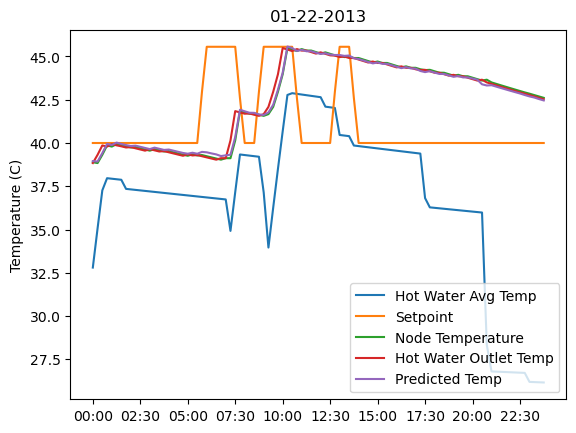

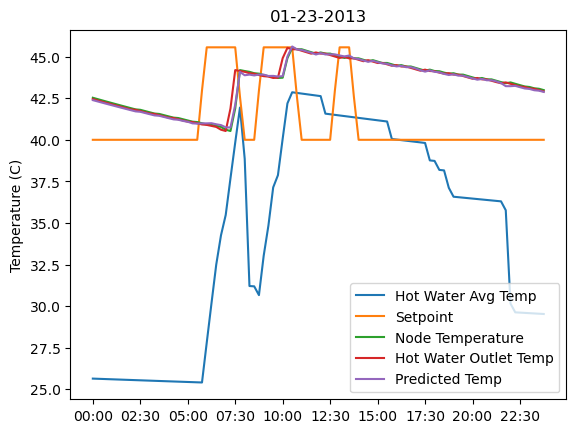

In [56]:
import matplotlib.pyplot as plt
#Create validation graphics

#get data for 1 day
#1440 minutes in a day / 15 = 96 windows in a day
days = {1, 2, 3, 4, 5, 6}
for day in days:
    x_day = X_val[(96*day):(96* day) + 96]
    avg_temp_day = x_day[:, 0]
    draw_data_day = x_day[:, 1]
    setpoint_day = x_day[:, 5]
    node_temp_day = x_day[:, 9]
    y_day = y_val[(96 * day):(96 * day) + 96]
    y_day = [list(row) for row in zip(*y_day)]
    y_day = y_day[0]
    y_predict_day = y_predict_val[(96 * day):(96 * day) + 96]
    y_predict_day = y_predict_day[:, 0]



    start_time = "00:00:00"
    end_time = "23:59:59"

    # Create datetime range with 15-minute intervals
    datetime_list = pd.date_range(start=start_time, end=end_time, freq="15T")

    # Convert to a list (optional)
    datetime_list = list(datetime_list)
    datetime_list = [dt.strftime("%H:%M") for dt in datetime_list]

    from datetime import datetime
    
    # initializing day number

    
    day_num = str((day + 17) % 365)
    
    # adjusting day num
    day_num.rjust(3 + len(day_num), '0')
    
    # Initialize year
    year = "2013"
    
    # converting to date
    res = datetime.strptime(year + "-" + day_num, "%Y-%j").strftime("%m-%d-%Y")
    

    import matplotlib.dates as mdates
    plt.figure()
    plt.plot(datetime_list, avg_temp_day, label = "Hot Water Avg Temp") #avg temp
    plt.plot(datetime_list, setpoint_day, label = "Setpoint")
    plt.plot(datetime_list, node_temp_day, label = "Node Temperature")
    plt.plot(datetime_list, y_day, label = "Hot Water Outlet Temp")
    plt.plot(datetime_list, y_predict_day, label = "Predicted Temp") #todo: add stagger of 15 minutes

    plt.title(str(res))

    plt.xticks(datetime_list[::10])
    plt.legend(loc='lower right')
    plt.ylabel("Temperature (C)")

In [ ]:
# We set Hot Water Outlet as our predicted value
import numpy as np
from sklearn.linear_model import LinearRegression

#Linear Regression
model = LinearRegression()
model.fit(X,y)
r_sq = model.score(X, y)
print(f"coefficient of determination: {r_sq}")


coefficient of determination: 0.9860939061394864


In [63]:
from sklearn.linear_model import Lasso
#Lasso 
lasso = Lasso(alpha=1.0) # alpha is the regularization strength
lasso.fit(X, y)
lasso.score(X, y)

0.9857133554804913

In [ ]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=1.0)
clf.fit(X, y)
clf.score(X, y)

0.9860939061394838

: 